In [1]:
import simdna
import simdna.synthetic as synthetic
import avutils
from avutils import util
reload(util)
import numpy as np
import momma_dragonn
reload(momma_dragonn)
import keras

In [2]:
def generate_sequences_set(seq_length, num_seqs, motif_names):
    loadedMotifs = synthetic.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001)
    embedInBackground = synthetic.EmbedInABackground(
        backgroundGenerator=synthetic.ZeroOrderBackgroundGenerator(seqLength=seq_length)
        , embedders=[
            synthetic.RepeatedEmbedder(
            synthetic.SubstringEmbedder(
                #synthetic.ReverseComplementWrapper(
                substringGenerator=synthetic.PwmSamplerFromLoadedMotifs(
                    loadedMotifs=loadedMotifs,motifName=motifName)
                #),
                ,positionGenerator=synthetic.UniformPositionGenerator()),
            quantityGenerator=
                synthetic.ZeroInflater(
                    #synthetic.MinMaxWrapper(synthetic.PoissonQuantityGenerator(1),theMax=1, theMin=0),
                    synthetic.FixedQuantityGenerator(1),
                    zeroProb=0.9)
            )
            for motifName in motif_names
        ]
    )
    sequenceSetGenerator = synthetic.GenerateSequenceNTimes(embedInBackground, num_seqs)
    return sequenceSetGenerator

def one_hot_encode_sequences_set(sequence_set_generator):
    one_hot_encoded_sequences = []
    for sequence in sequence_set_generator.generateSequences():
        one_hot_encoded_sequences.append(avutils.util.seq_to_2d_image(sequence.seq))
    return np.array(one_hot_encoded_sequences)

seq_length=45


motif_names = ["CTCF_known1"]#, "IRF_known1", "GATA_disc1"]

num_train_samples = 20000

one_hot_data_train_pos, one_hot_data_train_neg =\
 [one_hot_encode_sequences_set(generate_sequences_set(seq_length=seq_length, num_seqs=num_train_samples, motif_names=names))
  for names in [motif_names, []]]
one_hot_data_train_inputs = one_hot_data_train_pos #np.concatenate([one_hot_data_train_pos, one_hot_data_train_neg], axis=0)
one_hot_data_train_labels = one_hot_data_train_pos #np.concatenate([one_hot_data_train_pos, -one_hot_data_train_neg], axis=0)
_ = util.shuffle_arrays([one_hot_data_train_inputs, one_hot_data_train_labels], copy_on_shuffle=True)


In [3]:
reload(util)
one_hot_data_valid_pos, one_hot_data_valid_neg =\
 [one_hot_encode_sequences_set(generate_sequences_set(seq_length=seq_length, num_seqs=1000, motif_names=names))
  for names in [motif_names, []]]
one_hot_data_valid_inputs = one_hot_data_valid_pos #np.concatenate([one_hot_data_valid_pos, one_hot_data_valid_neg], axis=0)
one_hot_data_valid_labels = one_hot_data_valid_pos #np.concatenate([one_hot_data_valid_pos, -one_hot_data_valid_neg], axis=0)
_ = util.shuffle_arrays([one_hot_data_valid_inputs, one_hot_data_valid_labels], copy_on_shuffle=True)

In [4]:
import keras
reload(keras)
import keras.objectives
reload(keras.backend.theano_backend)
reload(keras.objectives)
from keras import backend
reload(backend)
import keras.layers.convolutional
reload(keras.layers.convolutional)
import momma_dragonn
reload(momma_dragonn)
reload(momma_dragonn.end_of_epoch_callbacks)
reload(momma_dragonn.data_loaders)
reload(momma_dragonn.model_evaluators)
reload(momma_dragonn.model_trainers.keras_model_trainer)
reload(momma_dragonn.data_loaders.core)

def model_creator_func(nb_filter, pool_over_channels, activation):
    filter_width=20
    #maxpool_filter_width=seq_length-(filter_width-1) #pool over entire region for now
    maxpool_filter_width=20
    
    from keras.models import Graph
    graph = Graph() 
    graph.add_input(name="sequence", input_shape=(1,4,seq_length))
    #add convolutional layer
    graph.add_node(
        keras.layers.convolutional.Convolution2D(
            nb_filter=nb_filter, nb_row=4, nb_col=filter_width, activation=activation,
            W_regularizer=keras.regularizers.WeightRegularizer(l1=0.00001)),
        name="conv", input="sequence")
    #add maxpool filter layer
    graph.add_node(
        keras.layers.convolutional.MaxPoolFilter2D_CenteredPool_Sequence(pool_length=maxpool_filter_width, pool_over_channels=pool_over_channels),
        #keras.layers.convolutional.MaxPoolFilter2D_NonOverlapStrides(pool_size=(1,maxpool_filter_width)),
        name="filt", input="conv")
    #add a padding layer so deconv will be the right size
    graph.add_node(
        keras.layers.convolutional.ZeroPadding2D(padding=(0,filter_width-1)),
        name="padding", input="filt")
    #add a deconv layer to reconstruct the input
    graph.add_node(
        keras.layers.convolutional.Convolution2D(
            nb_filter=4, nb_row=1, nb_col=filter_width,
            W_regularizer=keras.regularizers.WeightRegularizer(l1=0.00001)),
        name="deconv", input="padding")
    #transpose to make the deconv axis the row axis
    graph.add_node(
        keras.layers.convolutional.ExchangeChannelsAndRows(),
        name="swapaxes", input="deconv")
    #softmax across rows
    graph.add_node(
        keras.layers.convolutional.SoftmaxAcrossRows(),
        name="output_softmax", input="swapaxes")
    #designate output node
    graph.add_output(name="output", input="output_softmax")
    #compile
    graph.compile(
        optimizer=keras.optimizers.Adam(),
        loss={"output": "one_hot_rows_categorical_cross_entropy"}
    )
    return graph

#data loaders
train_data_loader = momma_dragonn.data_loaders.core.BatchDataLoader_XYDictAPI(
                        X={'sequence': one_hot_data_train_inputs}, Y={'output': one_hot_data_train_labels},
                        weight={}, batch_size=200, num_to_load_for_eval=num_train_samples, bundle_x_and_y_in_generator=True)
valid_data_loader = momma_dragonn.data_loaders.core.AtOnceDataLoader_XYDictAPI(
                        X={'sequence': one_hot_data_valid_inputs}, Y={'output': one_hot_data_valid_labels})
#model evaluator
model_evaluator = momma_dragonn.model_evaluators.GraphAccuracyStats(
    key_metric="onehot_rows_crossent", all_metrics=["onehot_rows_crossent"])

#stopping criterion
stopping_criterion_config = {"class": "EarlyStopping", "kwargs": {"max_epochs": 300, "epochs_to_wait": 10}}

#callbacks
end_of_epoch_callbacks = []#momma_dragonn.end_of_epoch_callbacks.PrintPerfAfterEpoch(print_trend=True)]

#trainer
trainer = momma_dragonn.model_trainers.keras_model_trainer.KerasFitGeneratorModelTrainer(
    samples_per_epoch=num_train_samples, stopping_criterion_config=stopping_criterion_config)

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
Using Theano backend.


('Input modes', ['sequence'])
('Output modes', ['output'])


Solo filter

In [5]:
filters_per_motif=1
#model creator
model_creator = momma_dragonn.model_creators.flexible_keras.KerasModelFromFunc(
    func=lambda: model_creator_func(nb_filter=filters_per_motif*len(motif_names),pool_over_channels=False, activation="relu"),
    model_wrapper_class=momma_dragonn.model_wrappers.keras_model_wrappers.KerasGraphModelWrapper)    
#train model
model_wrapper, performance_history, training_metadata = trainer.train(model_wrapper=model_creator.get_model_wrapper(),
                                                          model_evaluator=model_evaluator,
                                                          valid_data_loader=valid_data_loader,
                                                          other_data_loaders={'train': train_data_loader},
                                                          end_of_epoch_callbacks=end_of_epoch_callbacks)
model = model_wrapper.model

Loading momma_dragonn.stopping_criteria.EarlyStopping
Loading validation data into memory
Loaded
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3833 - val_loss: 1.3789
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3743 - val_loss: 1.3712
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3691 - val_loss: 1.3689
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3676 - val_loss: 1.3683
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3670 - val_loss: 1.3682
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3665 - val_loss: 1.3677
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3660 - val_loss: 1.3671
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3654 - val_loss: 1.3666
Epoch 1/1
20000/20000 [==============================] - 3s - loss: 1.3649 - val_loss: 1.3661
Epoch 1/1
20000/20000 [==============================] - 

In [6]:
file_prefix="solofilter_10pcCTCF_45bp_centerpool_relu"

In [7]:
model_wrapper.create_files_to_save(directory="models", prefix=file_prefix)

In [ ]:
from keras.models import model_from_yaml                                    
model = model_from_yaml(open("models/"+file_prefix+"_modelYaml.yaml").read())
model.load_weights("models/"+file_prefix+"_modelWeights.h5")

In [8]:
%matplotlib inline
#import deepLIFT stuff
import os, sys
import numpy as np
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
import deepLIFTutils
reload(deepLIFTutils)

def sortAndPrintFilters(weights,biases):
    filterScores = np.sum((np.max(weights,axis=-2)-np.min(weights,axis=-2)),axis=-1)[:,0]
    sortedFilters = sorted(enumerate(filterScores), key=lambda x: -x[1])
    deepLIFTutils.plotPositiveAndNegativeOutlierFilters(sortedFilters=sortedFilters
                                                        , numPositiveOutliers=len(weights)
                                                        , numNegativeOutliers=0
                                                        , weights=weights
                                                        , biases=np.zeros(len(weights))
                                                        , printBias=False
                                                        , figSize=(10,2))

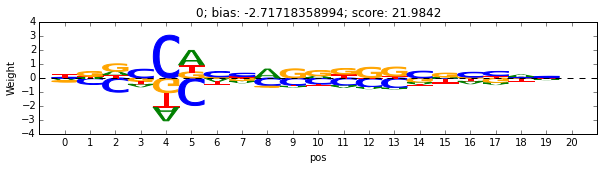

In [9]:
weights, biases = model.nodes['conv'].get_weights()
sortAndPrintFilters(weights, biases)

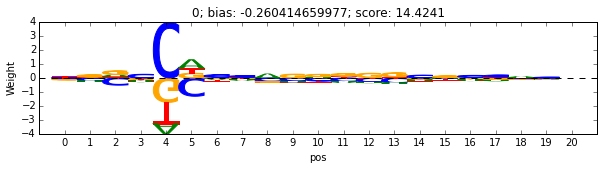

In [10]:
deconv_weights, deconv_biases = model.nodes['deconv'].get_weights()
sortAndPrintFilters(np.transpose(deconv_weights,(1,2,0,3))[:,:,::-1,::-1], deconv_biases)

20 filter, no channel pool

In [11]:
filters_per_motif=20
#model creator
model_creator = momma_dragonn.model_creators.flexible_keras.KerasModelFromFunc(
    func=lambda: model_creator_func(nb_filter=filters_per_motif*len(motif_names), pool_over_channels=False, activation="relu"),
    model_wrapper_class=momma_dragonn.model_wrappers.keras_model_wrappers.KerasGraphModelWrapper)    
#train model
model_wrapper, performance_history, training_metadata = trainer.train(model_wrapper=model_creator.get_model_wrapper(),
                                                          model_evaluator=model_evaluator,
                                                          valid_data_loader=valid_data_loader,
                                                          other_data_loaders={'train': train_data_loader},
                                                          end_of_epoch_callbacks=end_of_epoch_callbacks)
model = model_wrapper.model

Loading momma_dragonn.stopping_criteria.EarlyStopping
Loading validation data into memory
Loaded
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3111 - val_loss: 1.2059
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.1543 - val_loss: 1.1266
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.1186 - val_loss: 1.1119
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.1091 - val_loss: 1.1058
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.1032 - val_loss: 1.1009
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.0989 - val_loss: 1.0974
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.0958 - val_loss: 1.0944
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.0929 - val_loss: 1.0915
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.0905 - val_loss: 1.0894
Epoch 1/1
20000/20000 [==============================] - 

In [12]:
file_prefix="20filter_10pcCTCF_45bp_centerpool_nochannelpool_relu"

In [13]:
model_wrapper.create_files_to_save(directory="models", prefix=file_prefix)

In [ ]:
from keras.models import model_from_yaml                                    
model = model_from_yaml(open("models/"+file_prefix+"_modelYaml.yaml").read())
model.load_weights("models/"+file_prefix+"_modelWeights.h5")

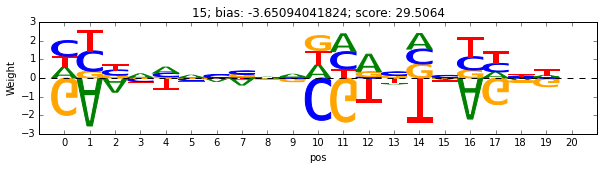

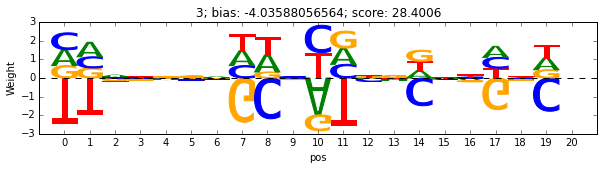

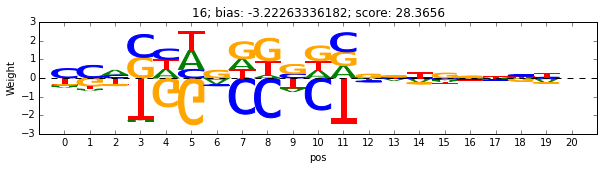

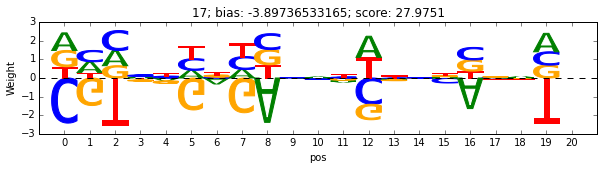

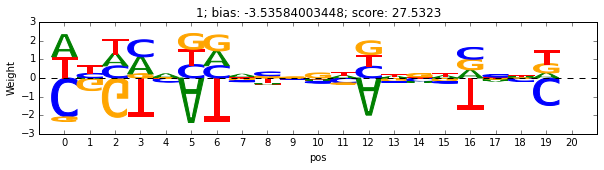

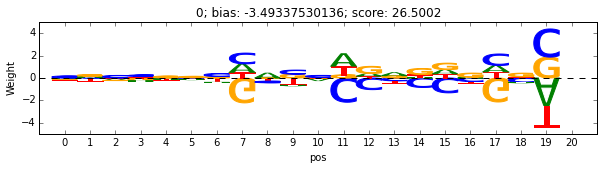

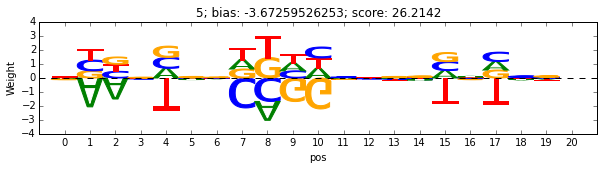

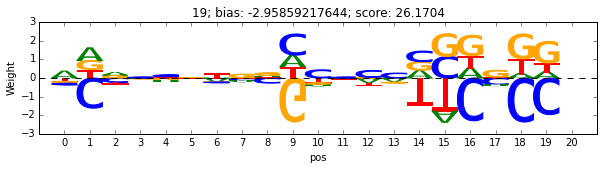

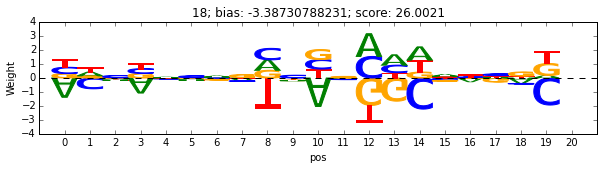

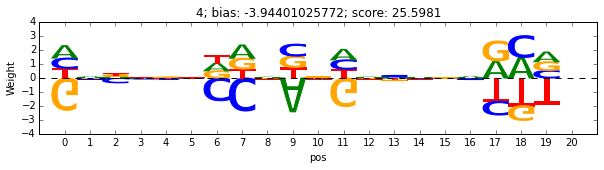

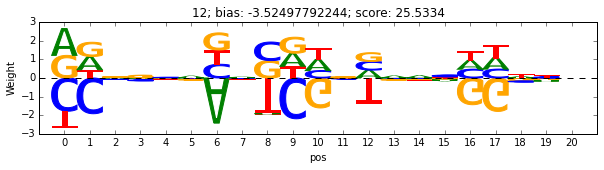

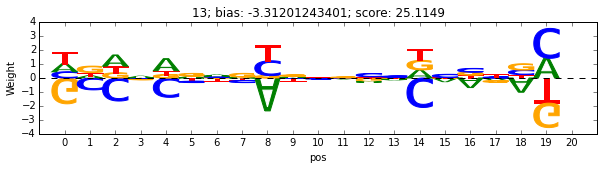

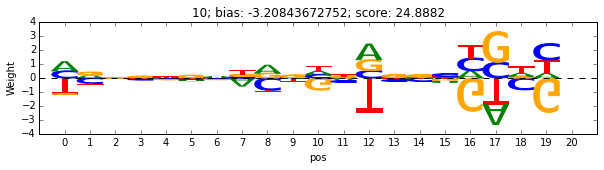

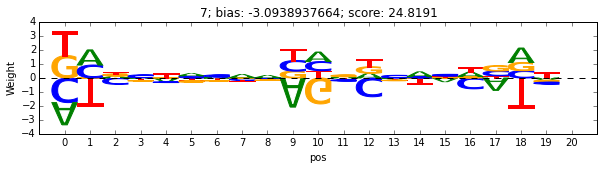

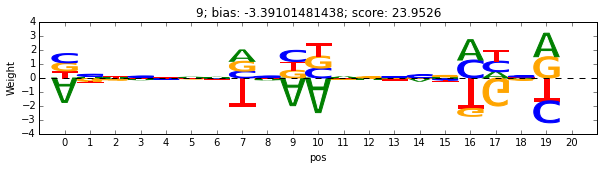

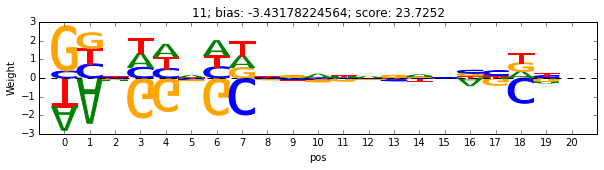

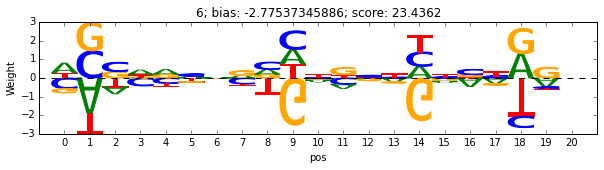

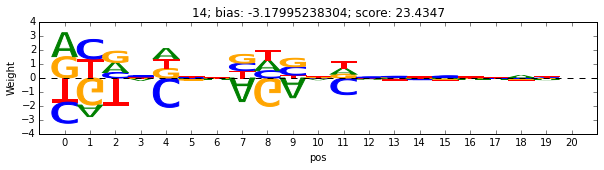

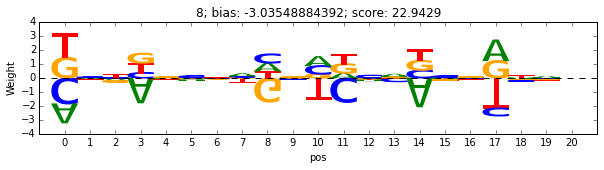

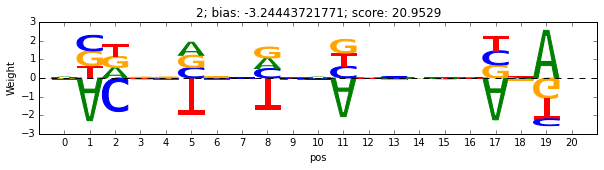

In [14]:
weights, biases = model.nodes['conv'].get_weights()
sortAndPrintFilters(weights, biases)

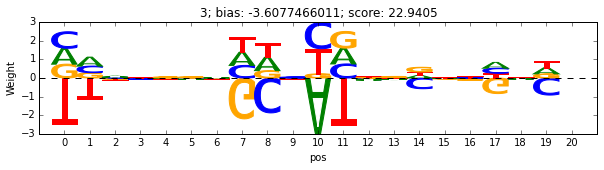

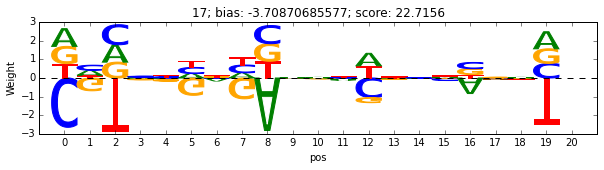

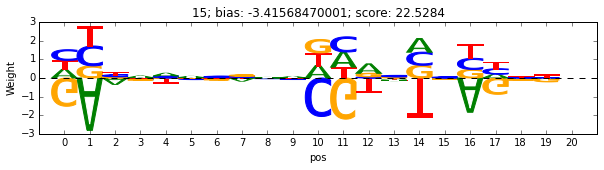

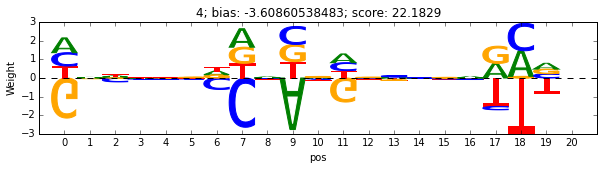

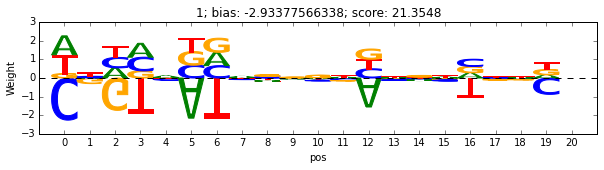

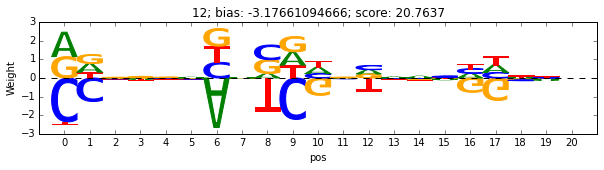

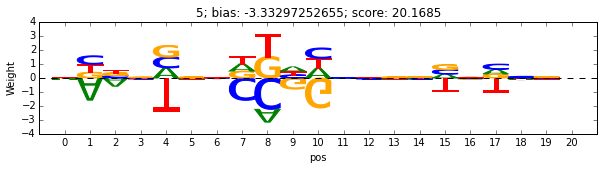

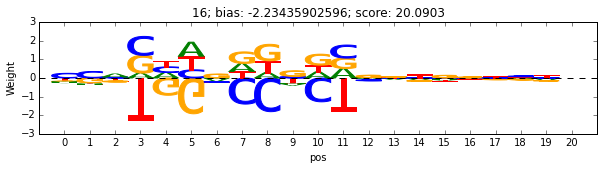

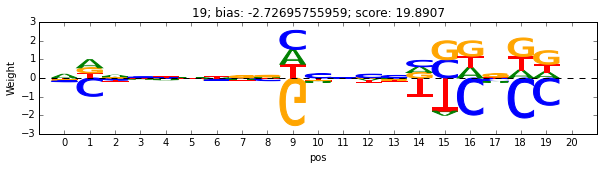

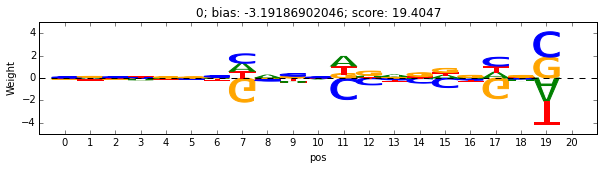

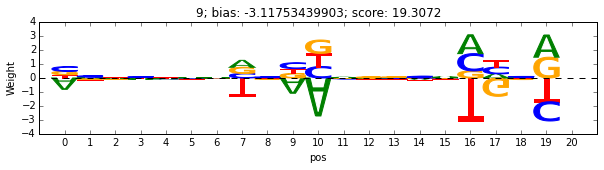

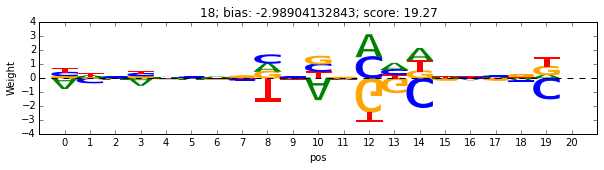

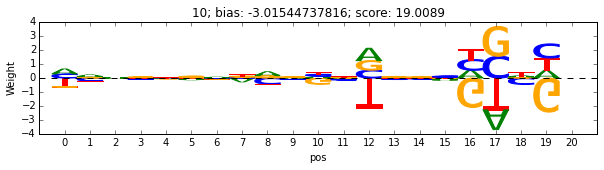

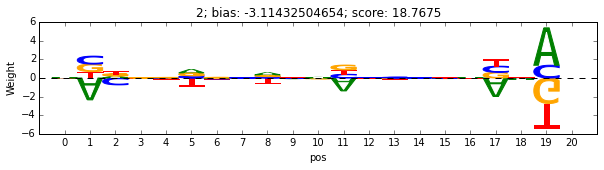

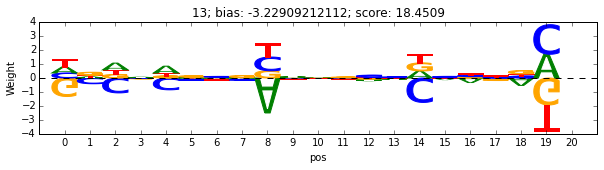

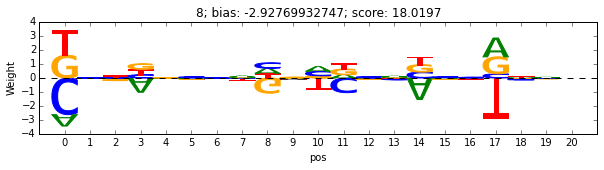

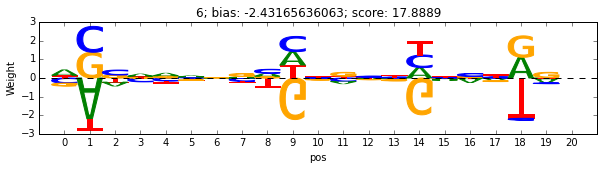

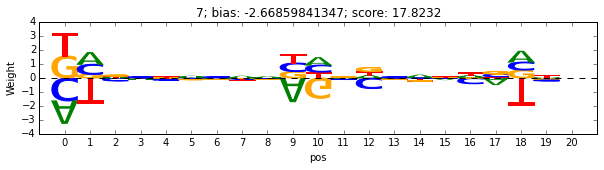

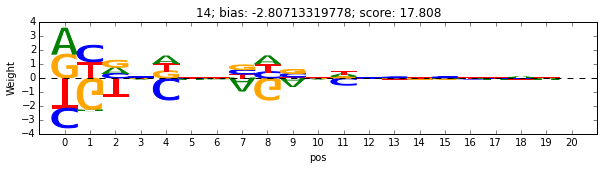

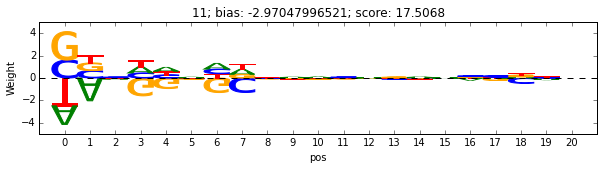

In [15]:
deconv_weights, deconv_biases = model.nodes['deconv'].get_weights()
sortAndPrintFilters(np.transpose(deconv_weights,(1,2,0,3))[:,:,::-1,::-1], deconv_biases)

20 filter, pool over channels

In [16]:
filters_per_motif=20
#model creator
model_creator = momma_dragonn.model_creators.flexible_keras.KerasModelFromFunc(
    func=lambda: model_creator_func(nb_filter=filters_per_motif*len(motif_names), pool_over_channels=True, activation="sigmoid"),
    model_wrapper_class=momma_dragonn.model_wrappers.keras_model_wrappers.KerasGraphModelWrapper)    
#train model
model_wrapper, performance_history, training_metadata = trainer.train(model_wrapper=model_creator.get_model_wrapper(),
                                                          model_evaluator=model_evaluator,
                                                          valid_data_loader=valid_data_loader,
                                                          other_data_loaders={'train': train_data_loader},
                                                          end_of_epoch_callbacks=end_of_epoch_callbacks)
model = model_wrapper.model

Loading momma_dragonn.stopping_criteria.EarlyStopping
Loading validation data into memory
Loaded
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3841 - val_loss: 1.3790
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3780 - val_loss: 1.3751
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3745 - val_loss: 1.3724
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3724 - val_loss: 1.3709
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3710 - val_loss: 1.3699
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3701 - val_loss: 1.3691
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3696 - val_loss: 1.3690
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3694 - val_loss: 1.3684
Epoch 1/1
20000/20000 [==============================] - 4s - loss: 1.3693 - val_loss: 1.3681
Epoch 1/1
20000/20000 [==============================] - 

In [17]:
file_prefix="20filter_10pcCTCF_45bp_centerpool_channelpool_sigmoid"

In [18]:
model_wrapper.create_files_to_save(directory="models", prefix=file_prefix)

In [ ]:
from keras.models import model_from_yaml                                    
model = model_from_yaml(open("models/"+file_prefix+"_modelYaml.yaml").read())
model.load_weights("models/"+file_prefix+"_modelWeights.h5")

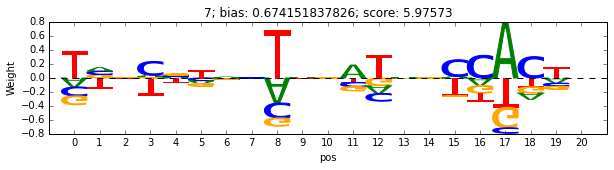

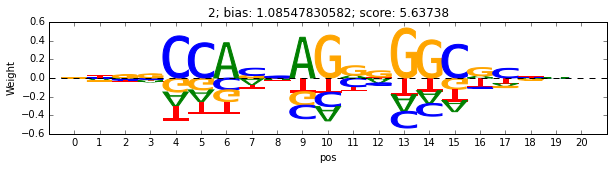

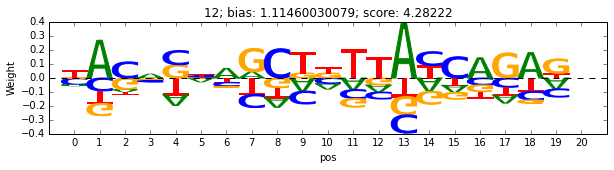

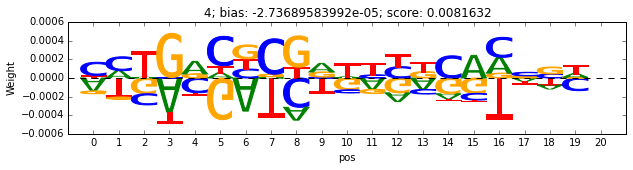

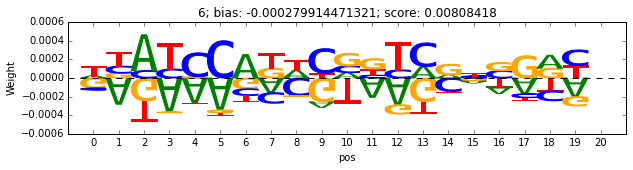

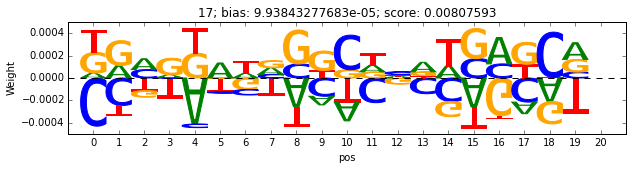

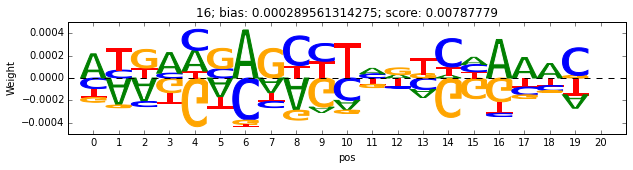

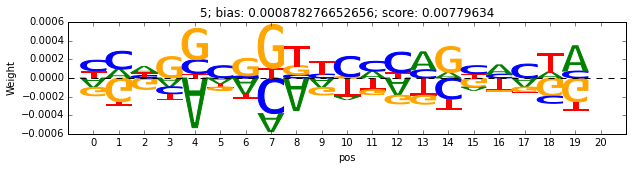

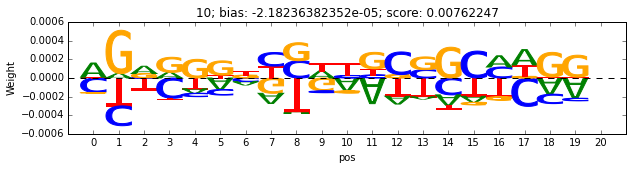

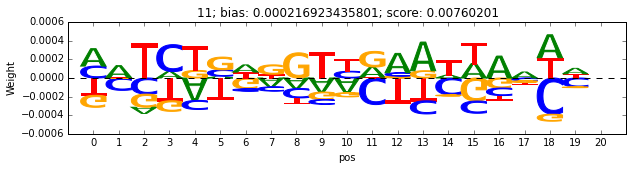

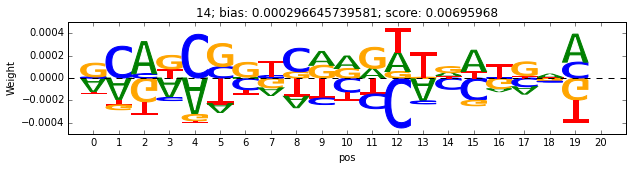

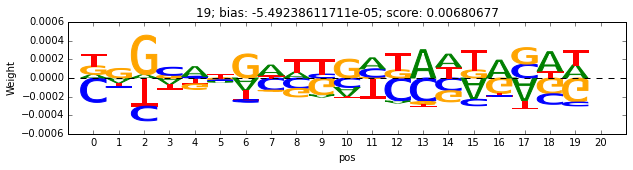

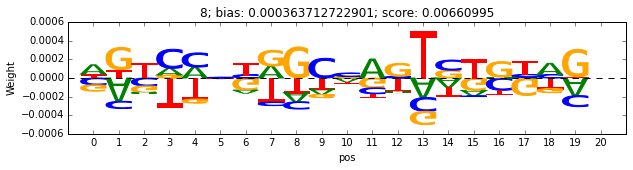

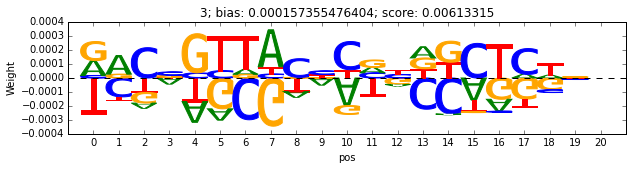

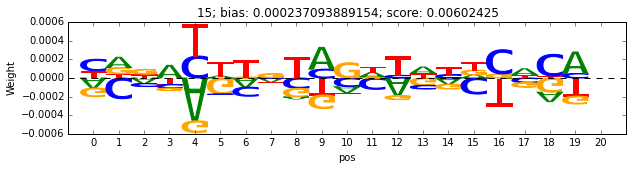

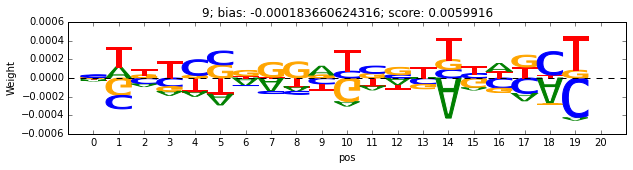

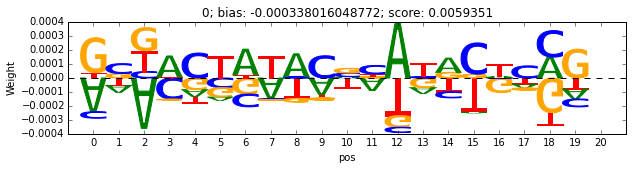

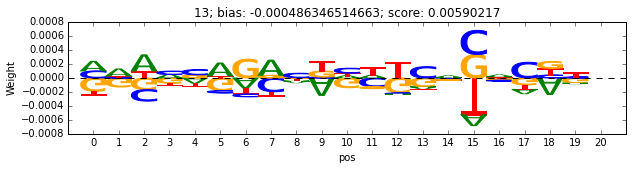

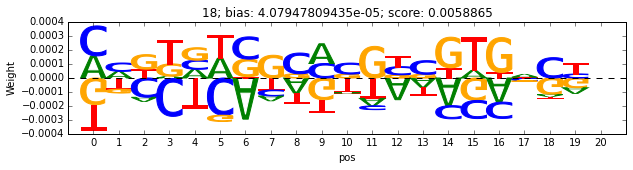

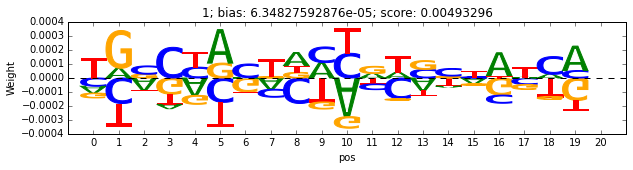

In [19]:
weights, biases = model.nodes['conv'].get_weights()
sortAndPrintFilters(weights, biases)

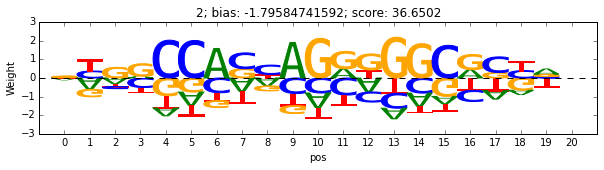

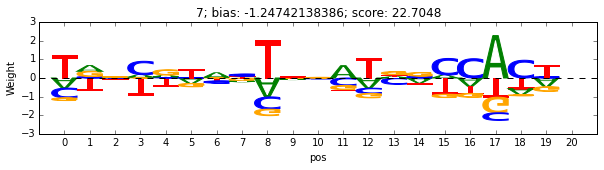

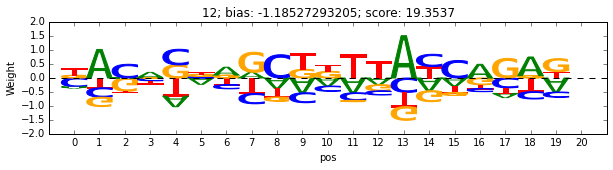

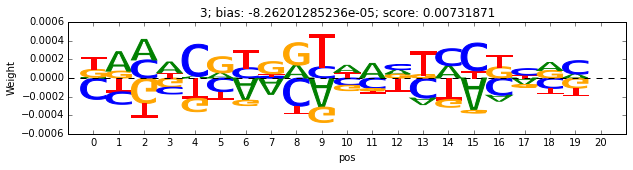

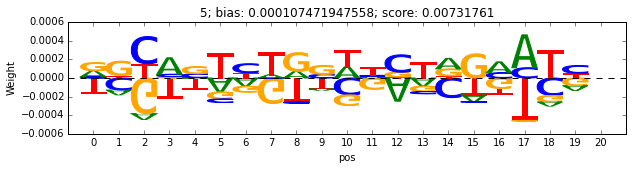

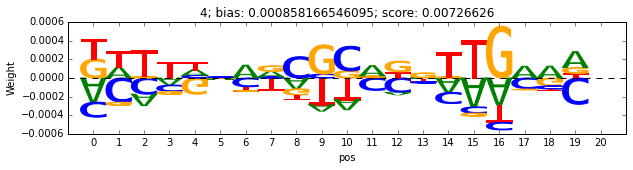

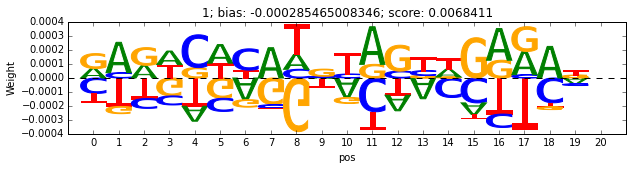

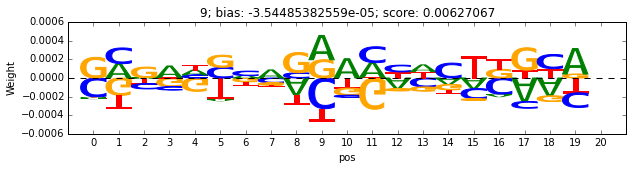

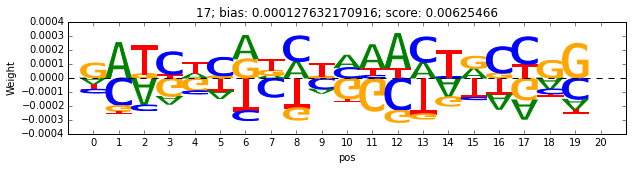

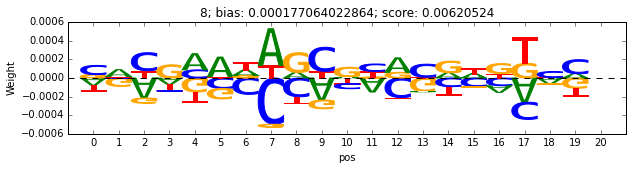

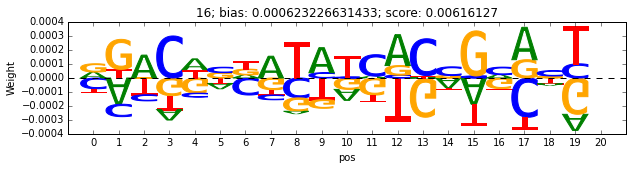

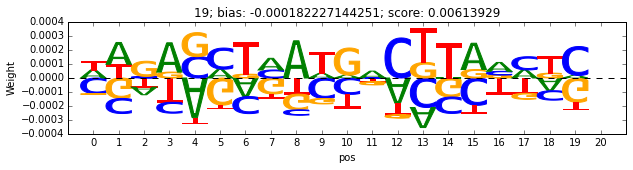

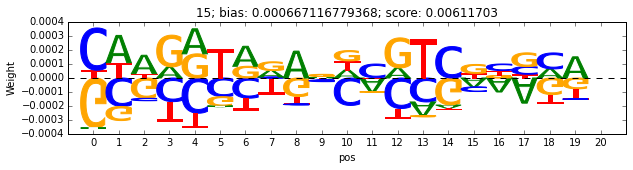

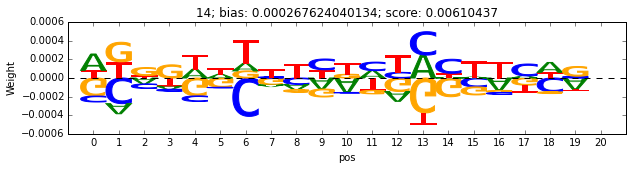

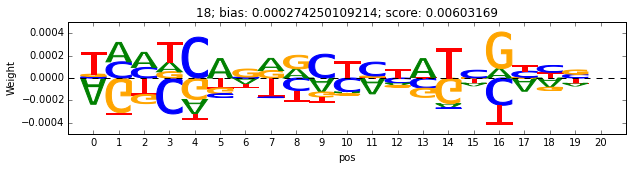

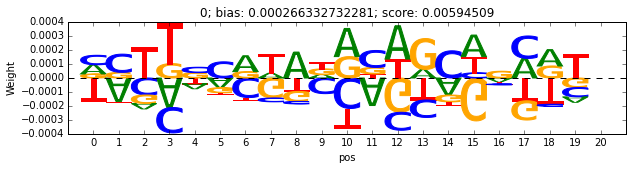

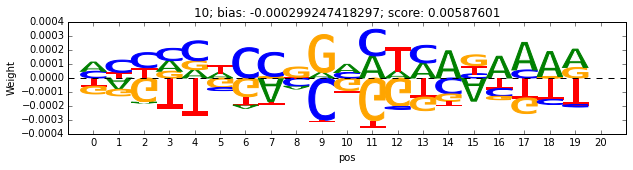

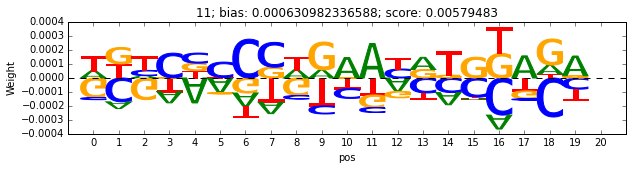

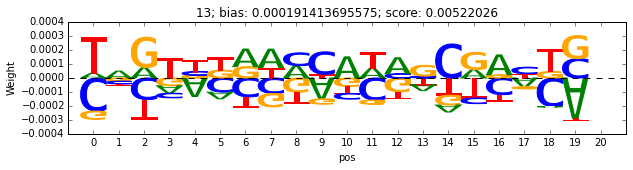

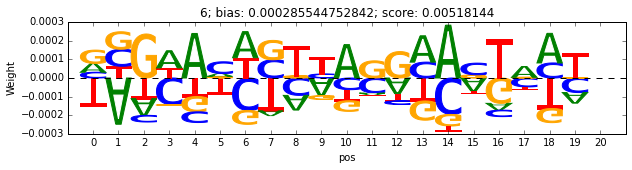

In [20]:
deconv_weights, deconv_biases = model.nodes['deconv'].get_weights()
sortAndPrintFilters(np.transpose(deconv_weights,(1,2,0,3))[:,:,::-1,::-1], deconv_biases)